## BO with TuRBO-1 and TS/qEI

In this tutorial, we show how to implement Trust Region Bayesian Optimization (TuRBO) [1] in a closed loop in BoTorch.

This implementation uses one trust region (TuRBO-1) and supports either parallel expected improvement (qEI) or Thompson sampling (TS). We optimize the $20D$ Ackley function on the domain $[-5, 10]^{20}$ and show that TuRBO-1 outperforms qEI as well as Sobol.

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_x -f(x)=0$.

[1]: [Eriksson, David, et al. Scalable global optimization via local Bayesian optimization. Advances in Neural Information Processing Systems. 2019](https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf)


In [6]:
import math
import os
from dataclasses import dataclass

import gpytorch
import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior
from torch.quasirandom import SobolEngine

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Optimize the 20-dimensional Ackley function

The goal is to minimize the popular Ackley function:

$f(x_1,\ldots,x_d) = -20\exp\left(-0.2 \sqrt{\frac{1}{d} \sum_{j=1}^d x_j^2} \right) -\exp \left( \frac{1}{d} \sum_{j=1}^d \cos(2 \pi x_j) \right) + 20 + e$

over the domain  $[-5, 10]^{20}$.  The global optimal value of $0$ is attained at $x_1 = \ldots = x_d = 0$.

As mentioned above, since botorch assumes a maximization problem, we instead maximize $-f(x)$.

In [7]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky


def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

## Maintain the TuRBO state
TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. 

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation. 

**Note**: These settings assume that the domain has been scaled to $[0, 1]^d$ and that the same batch size is used for each iteration.

In [8]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(max([4.0 / self.batch_size, float(self.dim) / self.batch_size]))


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

In [27]:
# For the SCBO algorithm
@dataclass
class SCBOTurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 10  # Note: The original paper uses 3
    best_value: float = -float("inf")
    best_constraint_values = (
        torch.ones(
            2,
        )
        * torch.inf
    )
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(max([4.0 / self.batch_size, float(self.dim) / self.batch_size]))


def update_tr_length(state):
    # Update the length of the trust region according to
    # success and failure counters
    # (Just as in original TuRBO paper)
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    if state.length < state.length_min:  # Restart when trust region becomes too small
        state.restart_triggered = True

    return state


def update_scbo_state(state, Y_next, C_next):
    """Method used to update the TuRBO state after each
    step of optimization.

    Success and failure counters are updated accoding to
    the objective values (Y_next) and constraint values (C_next)
    of the batch of candidate points evaluated on the optimization step.

    As in the original TuRBO paper, a success is counted whenver
    any one of the new candidate points imporves upon the incumbent
    best point. The key difference for SCBO is that we only compare points
    by their objective values when both points are valid (meet all constraints).
    If exactly one of the two points beinc compared voliates a constraint, the
    other valid point is automatically considered to be better. If both points
    violate some constraints, we compare them inated by their constraint values.
    The better point in this case is the one with minimum total constraint violation
    (the minimum sum over constraint values)"""

    # Determine which candidates meet the constraints (are valid)
    bool_tensor = C_next <= 0
    bool_tensor = torch.all(bool_tensor, dim=-1)
    Valid_Y_next = Y_next[bool_tensor]
    Valid_C_next = C_next[bool_tensor]
    if Valid_Y_next.numel() == 0:  # if none of the candidates are valid
        # pick the point with minimum violation
        sum_violation = C_next.sum(dim=-1)
        min_violation = sum_violation.min()
        # if the minimum voilation candidate is smaller than the violation of the incumbent
        if min_violation < state.best_constraint_values.sum():
            # count a success and update the current best point and constraint values
            state.success_counter += 1
            state.failure_counter = 0
            # new best is min violator
            state.best_value = Y_next[sum_violation.argmin()].item()
            state.best_constraint_values = C_next[sum_violation.argmin()]
        else:
            # otherwise, count a failure
            state.success_counter = 0
            state.failure_counter += 1
    else:  # if at least one valid candidate was suggested,
        # throw out all invalid candidates
        # (a valid candidate is always better than an invalid one)

        # Case 1: if best valid candidate found has a higher obj value that incumbent best
        # count a success, the obj valuse has been improved
        imporved_obj = max(Valid_Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value)
        # Case 2: if incumbent best violates constraints
        # count a success, we now have suggested a point which is valid and therfore better
        obtained_validity = torch.all(state.best_constraint_values > 0)
        if imporved_obj or obtained_validity:  # If Case 1 or Case 2
            # count a success and update the best value and constraint values
            state.success_counter += 1
            state.failure_counter = 0
            state.best_value = max(Valid_Y_next).item()
            state.best_constraint_values = Valid_C_next[Valid_Y_next.argmax()]
        else:
            # otherwise, count a fialure
            state.success_counter = 0
            state.failure_counter += 1

    # Finally, update the length of the trust region according to the
    # updated success and failure counts
    state = update_tr_length(state)

    return state

## Take a look at the state

In [9]:
state = TurboState(dim=dim, batch_size=batch_size)
print(state)

TurboState(dim=20, batch_size=4, length=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, failure_tolerance=5, success_counter=0, success_tolerance=10, best_value=-inf, restart_triggered=False)


## Generate initial points
This generates an initial set of Sobol points that we use to start of the BO loop.

In [10]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

## Generate new batch
Given the current `state` and a probabilistic (GP) `model` built from observations `X` and `Y`, we generate a new batch of points.  

This method works on the domain $[0, 1]^d$, so make sure to not pass in observations from the true domain.  `unnormalize` is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the `acqf` argument.

In [19]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next


def generate_scbo_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    constraint_model=None,
):
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    # Thompson Sampling w/ Constraints (SCBO)
    dim = X.shape[-1]
    sobol = SobolEngine(dim, scramble=True)
    pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
    pert = tr_lb + (tr_ub - tr_lb) * pert

    # Create a perturbation mask
    prob_perturb = min(20.0 / dim, 1.0)
    mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
    ind = torch.where(mask.sum(dim=1) == 0)[0]
    mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

    # Create candidate points from the perturbations and the mask
    X_cand = x_center.expand(n_candidates, dim).clone()
    X_cand[mask] = pert[mask]

    # Sample on the candidate points using Constrained Max Posterior Sampling
    constrained_thompson_sampling = ConstrainedMaxPosteriorSampling(
        model=model, constraint_model=constraint_model, replacement=False
    )
    with torch.no_grad():
        X_next = constrained_thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

## Optimization loop
This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion.  Once TuRBO converges, `state["restart_triggered"]` will be set to true and the run should be aborted.  If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded.  It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a `SingleTaskGP` with a noise constraint to keep the noise from getting too large as the problem is noise-free. 

In [12]:
X_turbo = get_initial_points(dim, n_init)
Y_turbo = torch.tensor([eval_objective(x) for x in X_turbo], dtype=dtype, device=device).unsqueeze(-1)

state = TurboState(dim, batch_size=batch_size)

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4


while not state.restart_triggered:  # Run until TuRBO converges
    # Fit a GP model
    train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(X_turbo, train_Y, covar_module=covar_module, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_model(mll)

        # Create a batch
        X_next = generate_batch(
            state=state,
            model=model,
            X=X_turbo,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ts",
        )

    Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)

    # Update state
    state = update_state(state=state, Y_next=Y_next)

    # Append data
    X_turbo = torch.cat((X_turbo, X_next), dim=0)
    Y_turbo = torch.cat((Y_turbo, Y_next), dim=0)

    # Print current status
    print(f"{len(X_turbo)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")

44) Best value: -1.29e+01, TR length: 8.00e-01
48) Best value: -9.74e+00, TR length: 8.00e-01
52) Best value: -9.74e+00, TR length: 8.00e-01
56) Best value: -8.96e+00, TR length: 8.00e-01
60) Best value: -8.96e+00, TR length: 8.00e-01
64) Best value: -8.96e+00, TR length: 8.00e-01
68) Best value: -8.96e+00, TR length: 8.00e-01
72) Best value: -8.96e+00, TR length: 8.00e-01
76) Best value: -8.96e+00, TR length: 4.00e-01
80) Best value: -7.78e+00, TR length: 4.00e-01
84) Best value: -7.78e+00, TR length: 4.00e-01
88) Best value: -6.72e+00, TR length: 4.00e-01
92) Best value: -6.72e+00, TR length: 4.00e-01
96) Best value: -6.72e+00, TR length: 4.00e-01
100) Best value: -6.72e+00, TR length: 4.00e-01
104) Best value: -6.72e+00, TR length: 4.00e-01
108) Best value: -6.72e+00, TR length: 2.00e-01
112) Best value: -5.78e+00, TR length: 2.00e-01
116) Best value: -5.14e+00, TR length: 2.00e-01
120) Best value: -5.14e+00, TR length: 2.00e-01
124) Best value: -4.82e+00, TR length: 2.00e-01
128) B

## SCBO

In [21]:
def c1(x):  # Equivalent to enforcing that x[0] >= 0
    return -x[0]


def c2(x):  # Equivalent to enforcing that x[1] >= 0
    return -x[1]


# We assume c1, c2 have same bounds as the Ackley function above
def eval_c1(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c1(unnormalize(x, fun.bounds))


def eval_c2(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return c2(unnormalize(x, fun.bounds))

In [22]:
# Get initial data
# Must get initial values for both objective and constraints
train_X = get_initial_points(dim, n_init)
train_Y = torch.tensor([eval_objective(x) for x in train_X], dtype=dtype, device=device).unsqueeze(-1)
C1 = torch.tensor([eval_c1(x) for x in train_X], dtype=dtype, device=device).unsqueeze(-1)
C2 = torch.tensor([eval_c2(x) for x in train_X], dtype=dtype, device=device).unsqueeze(-1)

C1.min(), C1.max(), C2.min(), C2.max(), train_Y.min(), train_Y.max()

(tensor(-9.6854, dtype=torch.float64),
 tensor(4.8509, dtype=torch.float64),
 tensor(-9.8032, dtype=torch.float64),
 tensor(4.7317, dtype=torch.float64),
 tensor(-15.9292, dtype=torch.float64),
 tensor(-12.4023, dtype=torch.float64))

In [28]:
# Initialize TuRBO state
from botorch.generation.sampling import ConstrainedMaxPosteriorSampling
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize

state = SCBOTurboState(dim, batch_size=batch_size)
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4


def get_fitted_model(X, Y):
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0))
    )
    model = SingleTaskGP(X, Y, covar_module=covar_module, likelihood=likelihood, outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        fit_gpytorch_model(mll)

    return model


while not state.restart_triggered:  # Run until TuRBO converges
    # Fit GP models for objective and constraints
    model = get_fitted_model(train_X, train_Y)
    c1_model = get_fitted_model(train_X, C1)
    c2_model = get_fitted_model(train_X, C2)

    # Generate a batch of candidates
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        X_next = generate_scbo_batch(
            state=state,
            model=model,
            X=train_X,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            constraint_model=ModelListGP(c1_model, c2_model),
        )

    # Evaluate both the objective and constraints for the selected candidaates
    Y_next = torch.tensor([eval_objective(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)

    C1_next = torch.tensor([eval_c1(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)

    C2_next = torch.tensor([eval_c2(x) for x in X_next], dtype=dtype, device=device).unsqueeze(-1)

    C_next = torch.cat([C1_next, C2_next], dim=-1)

    # Update TuRBO state
    state = update_scbo_state(state, Y_next, C_next)

    # Append data
    #   Notice we append all data, even points that violate
    #   the constriants, this is so our constraint models
    #   can learn more about the constranit functions and
    #   gain confidence about where violation occurs
    train_X = torch.cat((train_X, X_next), dim=0)
    train_Y = torch.cat((train_Y, Y_next), dim=0)
    C1 = torch.cat((C1, C1_next), dim=0)
    C2 = torch.cat((C2, C2_next), dim=0)

    # Print current status
    #   Note: state.best_value is always the best objective value
    #   found so far which meets the constraints, or in the case
    #   that no points have been found yet which meet the constraints,
    #   it is the objective value of the point with the
    #   minimum constraint violation
    print(f"{len(train_X)}) Best value: {state.best_value:.2e}, TR length: {state.length:.2e}")

44) Best value: -1.48e+01, TR length: 8.00e-01
48) Best value: -1.16e+01, TR length: 8.00e-01
52) Best value: -1.16e+01, TR length: 8.00e-01
56) Best value: -1.08e+01, TR length: 8.00e-01
60) Best value: -1.08e+01, TR length: 8.00e-01
64) Best value: -9.18e+00, TR length: 8.00e-01
68) Best value: -8.50e+00, TR length: 8.00e-01
72) Best value: -8.50e+00, TR length: 8.00e-01
76) Best value: -8.50e+00, TR length: 8.00e-01
80) Best value: -8.50e+00, TR length: 8.00e-01
84) Best value: -8.50e+00, TR length: 8.00e-01
88) Best value: -8.50e+00, TR length: 4.00e-01
92) Best value: -7.19e+00, TR length: 4.00e-01
96) Best value: -7.19e+00, TR length: 4.00e-01
100) Best value: -6.50e+00, TR length: 4.00e-01
104) Best value: -6.50e+00, TR length: 4.00e-01
108) Best value: -6.32e+00, TR length: 4.00e-01
112) Best value: -6.32e+00, TR length: 4.00e-01
116) Best value: -5.45e+00, TR length: 4.00e-01
120) Best value: -5.45e+00, TR length: 4.00e-01
124) Best value: -5.45e+00, TR length: 4.00e-01
128) B

## GP-EI
As a baseline, we compare TuRBO to qEI

In [14]:
X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor([eval_objective(x) for x in X_ei], dtype=dtype, device=device).unsqueeze(-1)

while len(Y_ei) < len(Y_turbo):
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    Y_next = torch.tensor([eval_objective(x) for x in candidate], dtype=dtype, device=device).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)

    # Print current status
    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

44) Best value: -1.12e+01
48) Best value: -1.07e+01
52) Best value: -1.02e+01
56) Best value: -8.61e+00
60) Best value: -8.61e+00
64) Best value: -8.61e+00
68) Best value: -8.61e+00
72) Best value: -8.61e+00
76) Best value: -8.61e+00
80) Best value: -8.61e+00
84) Best value: -8.61e+00
88) Best value: -8.61e+00
92) Best value: -8.61e+00
96) Best value: -8.61e+00
100) Best value: -8.61e+00
104) Best value: -8.61e+00
108) Best value: -8.61e+00
112) Best value: -8.61e+00
116) Best value: -8.61e+00
120) Best value: -8.61e+00
124) Best value: -8.61e+00
128) Best value: -8.61e+00
132) Best value: -8.61e+00
136) Best value: -8.61e+00
140) Best value: -8.61e+00
144) Best value: -8.61e+00
148) Best value: -8.61e+00
152) Best value: -8.61e+00
156) Best value: -8.61e+00
160) Best value: -8.61e+00
164) Best value: -8.61e+00
168) Best value: -8.61e+00
172) Best value: -8.61e+00
176) Best value: -8.61e+00
180) Best value: -8.61e+00
184) Best value: -8.61e+00
188) Best value: -8.61e+00
192) Best value

## Sobol

In [15]:
X_Sobol = SobolEngine(dim, scramble=True, seed=0).draw(len(X_turbo)).to(dtype=dtype, device=device)
Y_Sobol = torch.tensor([eval_objective(x) for x in X_Sobol], dtype=dtype, device=device).unsqueeze(-1)

## Compare the methods

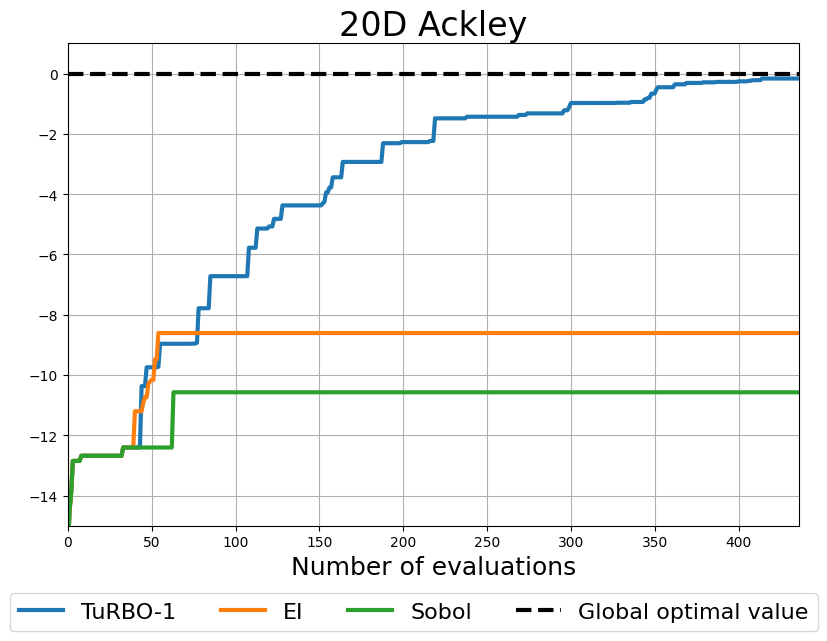

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline


names = ["TuRBO-1", "EI", "Sobol"]
runs = [Y_turbo, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_turbo)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_turbo)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()